In [28]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import torch.optim as optim
from pytorch_msssim import ssim, SSIM
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Preparation
- In case InVEST model error and the outputs weren't successfully generated, the samples should not be included in the training.
- Splitting the data into train, test, and validation.
- After splitting the data, calculate normalization parameters.

In [12]:
# Paths to input and output directories
os.chdir('E:/Coding/CNN_InV_ReOrg')
input_dir = 'Prosd'
output_dir = 'Results'
split_dir = 'Fix_Sets'
os.makedirs(split_dir, exist_ok=True)

In [13]:
def find_global_min_max(input_dir, output_dir, train_ids, val_ids, test_ids, normalization_file):
    # Initialize min and max trackers for input channels 1, 2 and gt channel 2
    global_min_input_1 = float('inf')
    global_max_input_1 = float('-inf')
    
    global_min_input_2 = float('inf')
    global_max_input_2 = float('-inf')
    
    global_min_gt_2 = float('inf')
    global_max_gt_2 = float('-inf')
    
    # Combine all file IDs
    all_ids = train_ids + val_ids + test_ids
    
    for fid in tqdm(all_ids, desc="Finding global min and max..."):
        try:
            # Load input and ground truth tensors
            input_path = os.path.join(input_dir, f'{fid}.pt')
            gt_path = os.path.join(output_dir, f'{fid}_res.pt')
            
            input_tensor = torch.load(input_path, weights_only=True).squeeze(1)  # Shape: (3, 512, 512)
            gt_tensor = torch.load(gt_path, weights_only=True).squeeze(1)  # Shape: (3, 512, 512)
            
            # Update min and max for input channel 1 (index 0)
            global_min_input_1 = min(global_min_input_1, input_tensor[1].min().item())
            global_max_input_1 = max(global_max_input_1, input_tensor[1].max().item())
            global_mean_input_1 = input_tensor[1].mean().item()
            global_std_input_1 = input_tensor[1].std().item()
            
            # Update min and max for input channel 2 (index 1)
            global_min_input_2 = min(global_min_input_2, input_tensor[2].min().item())
            global_max_input_2 = max(global_max_input_2, input_tensor[2].max().item())
            global_mean_input_2 = input_tensor[2].mean().item()
            global_std_input_2 = input_tensor[2].std().item()
            
            # Update min and max for gt channel 2 (index 2)
            global_min_gt_2 = min(global_min_gt_2, gt_tensor[2].min().item())
            global_max_gt_2 = max(global_max_gt_2, gt_tensor[2].max().item())
            global_mean_gt_2 = gt_tensor[2].mean().item()
            global_std_gt_2 = gt_tensor[2].std().item()
        
        except Exception as e:
            print(f"Skipping problematic sample {fid} due to error: {e}")
    
    # Save normalization parameters to file
    params = {
        'min_channel_1': global_min_input_1,
        'max_channel_1': global_max_input_1,
        'mean_channel_1': global_mean_input_1,
        'std_channel_1': global_std_input_1,
        'min_channel_2': global_min_input_2,
        'max_channel_2': global_max_input_2,
        'mean_channel_2': global_mean_input_2,
        'std_channel_2': global_std_input_2,
        'min_gt_channel_2': global_min_gt_2,
        'max_gt_channel_2': global_max_gt_2,
        'mean_gt_channel_2': global_mean_gt_2,
        'std_gt_channel_2': global_std_gt_2
    }
    
    np.save(normalization_file, params)
    print(f"Global min and max values saved to {normalization_file}.")



In [10]:
# BE CAREFUL WHEN RUNNING 
input_files = glob.glob(os.path.join(input_dir, '*.pt'))
output_files = glob.glob(os.path.join(output_dir, '*_res.pt'))

# Extract file IDs from both input and output files
output_ids = {os.path.basename(f).split('_res.pt')[0] for f in output_files}
file_ids = [os.path.basename(f).split('.pt')[0] for f in input_files if not f.endswith('_res.pt')]

# Only include files that have corresponding outputs
valid_file_ids = [fid for fid in file_ids if fid in output_ids]

# Filtering function to check data validity
def is_valid_data(data):
    # Check if channel 0 has more than one unique value
    if len(torch.unique(data[0])) <= 1:

        return False
    # Check if channel 1 or 2 contains nodata values 65535 or -99999
    if torch.any(data[1] == 65535) or torch.any(data[2] == -99999):
        print(f'Invalid data found: {data[1].min()}, {data[1].max()}, {data[2].min()}, {data[2].max()}')
        return False
    return True

# Load and filter the data with a progress bar
filtered_file_ids = []
for fid in tqdm(valid_file_ids, desc="Filtering data"):
    file_path = os.path.join(input_dir, f'{fid}.pt')
    data = torch.load(file_path, weights_only=True)
    # Ensure the data shape is (3, 512, 512) and apply the validity checks
    if is_valid_data(data):
        filtered_file_ids.append(fid)

# Save the filtered file IDs to a CSV file
csv_path = os.path.join(split_dir, 'filtered_file_ids.csv')
pd.DataFrame(filtered_file_ids, columns=['file_id']).to_csv(csv_path, index=False)

# Split data: 70% for training, 30% for further splitting
train_ids, temp_ids = train_test_split(filtered_file_ids, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Save the split IDs for future reload
pd.DataFrame(train_ids, columns=['file_id']).to_csv(os.path.join(split_dir, 'train_ids.csv'), index=False)
pd.DataFrame(val_ids, columns=['file_id']).to_csv(os.path.join(split_dir, 'val_ids.csv'), index=False)
pd.DataFrame(test_ids, columns=['file_id']).to_csv(os.path.join(split_dir, 'test_ids.csv'), index=False)

Filtering data: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


In [14]:
# Code to reload the file IDs
def load_file_ids(split_dir, split_name):
    csv_path = os.path.join(split_dir, f'{split_name}_ids.csv')
    return pd.read_csv(csv_path)['file_id'].tolist()

# Reload the split IDs
train_ids = load_file_ids(split_dir, 'train')
val_ids = load_file_ids(split_dir, 'val')
test_ids = load_file_ids(split_dir, 'test')

In [15]:
# Call the function using example paths
find_global_min_max(input_dir=input_dir, output_dir=output_dir,
                    train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
                    normalization_file='Normal/normalization_params.npy')

# load normalization parameters
normp = np.load('Normal/normalization_params.npy', allow_pickle=True).item()

Finding global min and max...: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]

Global min and max values saved to Normal/normalization_params.npy.


# Dataloader

In [25]:
class CustomDataset(Dataset):
    def __init__(self, input_dir, output_dir, file_ids, transform=None, preload=True ,normalization_file='Normal/normalization_params.npy'):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.file_ids = file_ids
        self.transform = transform
        self.num_categories = 14  # Categories 1-12, 254->13, 255->14
        self.preload = preload
        self.data_cache = {}
        self.normalization_file = normalization_file
        self.mean_channel_1 = 0.0
        self.std_channel_1 = 1.0
        self.mean_channel_2 = 0.0
        self.std_channel_2 = 1.0
        
        # Load normalization parameters if they exist
        if os.path.exists(self.normalization_file):

            params = np.load(self.normalization_file, allow_pickle=True).item()
            self.min_channel_1 = params['min_channel_1']
            self.max_channel_1 = params['max_channel_1']
            self.mean_channel_1 = params['mean_channel_1']
            self.std_channel_1 = params['std_channel_1']
            self.min_channel_2 = params['min_channel_2']
            self.max_channel_2 = params['max_channel_2']
            self.mean_channel_2 = params['mean_channel_2']
            self.std_channel_2 = params['std_channel_2']
            self.min_gt_channel_2 = params['min_gt_channel_2']
            self.max_gt_channel_2 = params['max_gt_channel_2']
            self.mean_gt_channel_2 = params['mean_gt_channel_2']
            self.std_gt_channel_2 = params['std_gt_channel_2']
        else:
            print(f"Normalization file not found at {self.normalization_file}. Using default values.")

        if self.preload:

            for fid in tqdm(self.file_ids, desc="Pre-loading data into memory..."):
                input_path = os.path.join(self.input_dir, f'{fid}.pt')
                gt_path = os.path.join(self.output_dir, f'{fid}_res.pt')
                try:
                    input_tensor = torch.load(input_path, weights_only=True).squeeze(1)
                    gt_tensor = torch.load(gt_path, weights_only=True).squeeze(1)

                    # Process first channel
                    first_channel = input_tensor[0, :, :]
                    first_channel[first_channel == 254] = 13
                    first_channel[first_channel == 255] = 14
                    first_channel = first_channel - 1  # Adjust labels to start from 0

                    # One-hot encode and reshape
                    first_channel_ohe = F.one_hot(first_channel.long(), num_classes=self.num_categories)
                    first_channel_ohe = first_channel_ohe.permute(2, 0, 1)  # Shape: (num_categories, 512, 512)

                    # Concatenate with other channels
                    other_channels = input_tensor[1:, :, :].float()
                    other_channels[0] = (other_channels[0] - self.min_channel_1) / (self.max_channel_1 - self.min_channel_1 + 1e-8)
                    other_channels[1] = (other_channels[1] - self.min_channel_2) / (self.max_channel_2 - self.min_channel_2 + 1e-8)

                    gt_second_channel = (gt_tensor[2] - self.mean_gt_channel_2) / (self.std_gt_channel_2 + 1e-8)
                    gt_second_channel = torch.sign(gt_second_channel) * torch.log(torch.abs(gt_second_channel) + 1)
                    other_gt_channels = gt_tensor[:2]

                    final_input = torch.cat((first_channel_ohe.float(), other_channels.float()), dim=0)
                    final_gt = torch.cat((other_gt_channels, gt_second_channel.unsqueeze(0)), dim=0)

                    self.data_cache[fid] = (final_input, final_gt)

                except Exception as e:
                    print(f"Skipping problematic sample {fid} due to error: {e}")

                
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        fid = self.file_ids[idx]

        if self.preload and fid in self.data_cache:
            final_input, gt_tensor = self.data_cache[fid]
        else:
            input_path = os.path.join(self.input_dir, f'{fid}.pt')
            gt_path = os.path.join(self.output_dir, f'{fid}_res.pt')

            try:
                input_tensor = torch.load(input_path, weights_only=True).squeeze(1)
                gt_tensor = torch.load(gt_path, weights_only=True).squeeze(1)

                # Process first channel
                first_channel = input_tensor[0, :, :]
                first_channel[first_channel == 254] = 13
                first_channel[first_channel == 255] = 14
                first_channel = first_channel - 1  # Adjust labels to start from 0

                # One-hot encode and reshape
                first_channel_ohe = F.one_hot(first_channel.long(), num_classes=self.num_categories)
                first_channel_ohe = first_channel_ohe.permute(2, 0, 1)  # Shape: (num_categories, 512, 512)

                # Concatenate with other channels
                other_channels = input_tensor[1:, :, :]
                other_channels[0] = (other_channels[0] - self.min_channel_1) / (self.max_channel_1 - self.min_channel_1 + 1e-8)
                other_channels[1] = (other_channels[1] - self.min_channel_2) / (self.max_channel_2 - self.min_channel_2 + 1e-8)

                
                gt_second_channel = (gt_tensor[2] - self.mean_gt_channel_2) / (self.std_gt_channel_2 + 1e-8)
                gt_second_channel = torch.sign(gt_second_channel) * torch.log(torch.abs(gt_second_channel) + 1)
                other_gt_channels = gt_tensor[:2]

                final_input = torch.cat((first_channel_ohe.float(), other_channels.float()), dim=0)
                final_gt = torch.cat((other_gt_channels, gt_second_channel.unsqueeze(0)), dim=0)
                self.data_cache[fid] = (final_input, final_gt)

            except Exception as e:
                print(f"Skipping problematic sample {fid} due to error: {e}")
                return None  # Return None for problematic samples

        if self.transform:
            final_input = self.transform(final_input)
            gt_tensor = self.transform(gt_tensor)

        return final_input, gt_tensor.float()

# Adjust DataLoader to handle None values
def custom_collate_fn(batch):
    # Filter out None samples
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None  # Handle edge case where all samples are None
    return torch.utils.data.dataloader.default_collate(batch)


In [22]:
# Create datasets
train_dataset = CustomDataset(input_dir, output_dir, train_ids, preload=True)
val_dataset = CustomDataset(input_dir, output_dir, val_ids, preload=True)
test_dataset = CustomDataset(input_dir, output_dir, test_ids, preload=True)

# Update DataLoader initialization

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)

Pre-loading data into memory...: 100%|██████████| 2/2 [00:00<00:00, 71.15it/s]


##   Test dataloader, shape of data, & device

In [ ]:
# Test the DataLoader with a sample batch
# dataset = train_loader.dataset 
# try:
    # inputs, targets = dataset[5]  # Access first data point
    # print(f"Sample 0 loaded successfully.")
    # print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    # print max and min for each channel
    # for i in range(inputs.shape[0]):
        # print(f"Channel {i} - Min: {inputs[i].min().item()}, Max: {inputs[i].max().item()}")
    # for i in range(targets.shape[0]):
        # print(f"Channel {i} - Min: {targets[i].min().item()}, Max: {targets[i].max().item()}")
# except Exception as e:
    # print(f"Error loading the first sample: {e}")

# Test the shape and device of the first batch
# for i, (inputs, targets) in enumerate(train_loader):
    # print(f"Batch {i+1}:")
    # print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    # print(f"Input device: {inputs.device}, Target device: {targets.device}")
    # if i == 0:  # Test only the first batch
        # break

## Test via visualization

In [29]:
# change font to serif
plt.rcParams["font.family"] = "serif"

def visualize_raw_sample(input_dir, output_dir, fid):
    """
    Visualizes the original raw input (channel 0) and normalized channels 1 and 2, along with the ground truth (3 channels) tensors.
    """
    # Load the raw input and ground truth tensors
    input_tensor = torch.load(os.path.join(input_dir, f'{fid}.pt')).squeeze(1)  # Shape: (3, 512, 512)
    gt_tensor = torch.load(os.path.join(output_dir, f'{fid}_res.pt')).squeeze(1)  # Shape: (3, 512, 512)

    # Use channel 0 as is
    channel_0 = input_tensor[0]

    # Normalize channel 1 and channel 2
    channel_1 = (input_tensor[1] - normp['min_channel_1']) / (normp['max_channel_1'] - normp['min_channel_1'] + 1e-8)
    channel_2 = (input_tensor[2] - normp['min_channel_2']) / (normp['max_channel_2'] - normp['min_channel_2'] + 1e-8)

    gt_tensor[2] = (gt_tensor[2] - normp['min_gt_channel_2']) / (normp['max_gt_channel_2'] - normp['min_gt_channel_2'] + 1e-8)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot channel 0, normalized channel 1, and normalized channel 2 of input
    channels = [channel_0, channel_1, channel_2]
    for i in range(3):
        image = channels[i].squeeze().numpy()
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f'Input Channel {i} (Channel 0 raw, 1 & 2 normalized)')
        axes[0, i].axis('off')

    # Plot first three channels of ground truth
    for i in range(3):
        image = gt_tensor[i].squeeze().numpy()
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f'Ground Truth Channel {i}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()



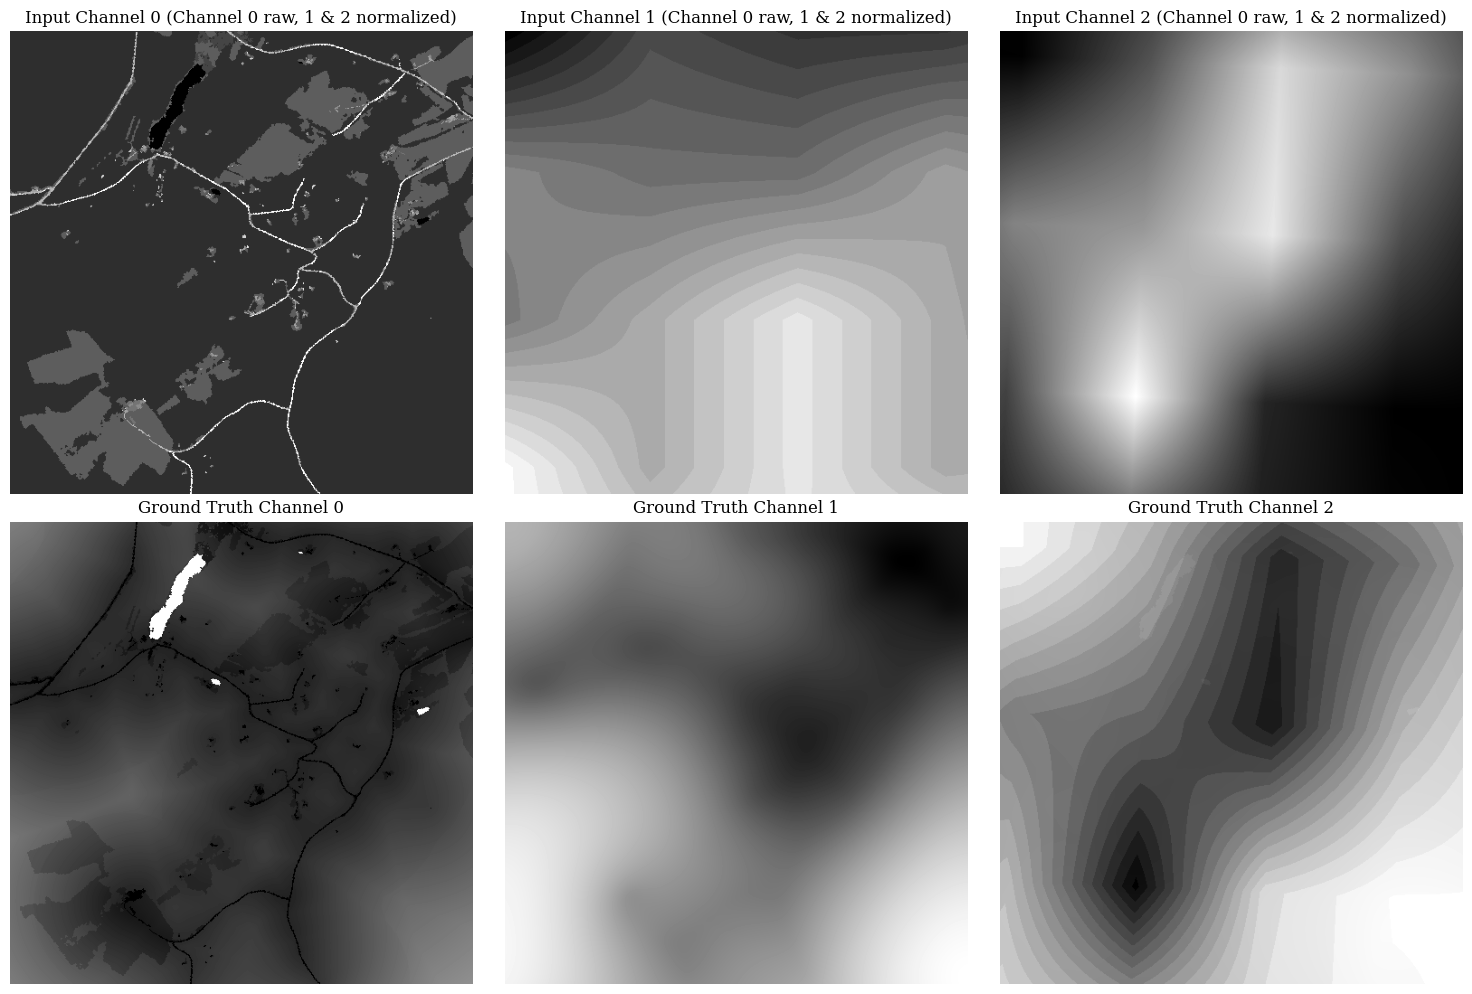

In [ ]:
# Select a file ID from the train dataset
sample_fid = train_ids[1]  # Or any valid file ID
# Visualize raw input and ground truth
visualize_raw_sample(input_dir, output_dir, sample_fid)

# Surrogate Model Architecture
## U-Net

In [ ]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block to recalibrate feature maps."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2, 3))  # Global average pooling
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        y = y.view(b, c, 1, 1)
        return x * y


class UNet(nn.Module):
    def __init__(self, in_channels=16, out_channels=3):
        super(UNet, self).__init__()
        # Define the encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder with skip connections
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)  # Concatenate
        self.se4 = SEBlock(512)  # Add SE attention to skip connection

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.se3 = SEBlock(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.se2 = SEBlock(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        self.se1 = SEBlock(64)

        # Output layer
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with SE-based attention for skip connections
        up4 = self.upconv4(b)
        skip4 = self.se4(e4)
        merge4 = torch.cat([up4, skip4], dim=1)
        d4 = self.decoder4(merge4)

        up3 = self.upconv3(d4)
        skip3 = self.se3(e3)
        merge3 = torch.cat([up3, skip3], dim=1)
        d3 = self.decoder3(merge3)

        up2 = self.upconv2(d3)
        skip2 = self.se2(e2)
        merge2 = torch.cat([up2, skip2], dim=1)
        d2 = self.decoder2(merge2)

        up1 = self.upconv1(d2)
        skip1 = self.se1(e1)
        merge1 = torch.cat([up1, skip1], dim=1)
        d1 = self.decoder1(merge1)

        # Output
        out = self.conv_last(d1)
        # out = torch.sigmoid(out)
        return out


### Test U-Net

In [32]:
# Instantiate the model
in_channels = 16  # {categories}+2 channels
out_channels = 3  # As specified
model = UNet(in_channels, out_channels).to('cuda')

# Create random input tensor
test_input = torch.randn(1, in_channels, 512, 512).to('cuda')
test_output = model(test_input)

print('Input shape:', test_input.shape)
print('Output shape:', test_output.shape)

Input shape: torch.Size([1, 16, 512, 512])
Output shape: torch.Size([1, 3, 512, 512])


## Attention UNet

In [33]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=16, out_channels=3):
        super(AttentionUNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with attention blocks for skip connections
        up4 = self.upconv4(b)
        att4 = self.att4(up4, e4)
        merge4 = torch.cat([up4, att4], dim=1)
        d4 = self.decoder4(merge4)

        up3 = self.upconv3(d4)
        att3 = self.att3(up3, e3)
        merge3 = torch.cat([up3, att3], dim=1)
        d3 = self.decoder3(merge3)

        up2 = self.upconv2(d3)
        att2 = self.att2(up2, e2)
        merge2 = torch.cat([up2, att2], dim=1)
        d2 = self.decoder2(merge2)

        up1 = self.upconv1(d2)
        att1 = self.att1(up1, e1)
        merge1 = torch.cat([up1, att1], dim=1)
        d1 = self.decoder1(merge1)

        # Output
        out = self.final(d1)
        return out


### Test Attention U-Net

In [ ]:
# Instantiate and test Attention UNet
# Define random input tensor
input_tensor = torch.randn(1, 16, 512, 512)
attention_unet = AttentionUNet(in_channels=16, out_channels=3)
output = attention_unet(input_tensor)
print('Attention UNet Output Shape:', output.shape)

# Deep Learning Model Training
## U-Net Training

In [ ]:
# Test a single batch from the train_loader
device = 'cuda'
mae_loss = nn.L1Loss()
# initialize model
model = UNet(in_channels=16, out_channels=3)
os.chdir(split_dir)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)
learning_rate = 0.00006
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training parameters
num_epochs = 20

Using device: cuda


In [35]:
# Weighted los
def debug_one_batch(model, train_loader, device):
    model.eval()  # Set model to evaluation mode for debugging
    with torch.no_grad():  # No gradients needed
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
            print(f"Input device: {inputs.device}, Target device: {targets.device}")

            # Forward pass for debugging
            outputs = model(inputs)
            print(f"Output shape: {outputs.shape}, Output device: {outputs.device}")

            # Compute losses for debugging
            ssim_loss_debug = 1 - ssim(outputs, targets, data_range=1, size_average=True)
            mae_debug = mae_loss(outputs, targets)
            alpha = ssim_loss_debug.item() / (ssim_loss_debug.item() + mae_debug.item())
            loss_debug = alpha * mae_debug + (1 - alpha) * ssim_loss_debug

            print(f"SSIM Loss (Debug): {ssim_loss_debug.item():.4f}")
            print(f"MAE Loss (Debug): {mae_debug.item():.4f}")
            print(f"Total Loss (Debug): {loss_debug.item():.4f}")

            # Exit after debugging one batch
            break

# Debug step before the training loop starts
debug_one_batch(model, train_loader, device)

Input shape: torch.Size([4, 16, 512, 512]), Target shape: torch.Size([4, 3, 512, 512])
Input device: cuda:0, Target device: cuda:0
Output shape: torch.Size([4, 3, 512, 512]), Output device: cuda:0
SSIM Loss (Debug): 1.0157
MAE Loss (Debug): 0.6582
Total Loss (Debug): 0.7987


In [ ]:
# Real UNet training loop
checkpoint_dir = "Checkpoints"
learning_rate = 0.00006
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = UNet(in_channels=16, out_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_number = 0
    total_batches = len(train_loader)
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # print data's device
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("Forward pass completed")
        ssim_loss = 1 - ssim(outputs, targets, data_range=1, size_average=True)
        mae = mae_loss(outputs, targets)
        # Total loss
        alpha = ssim_loss.item() / (ssim_loss.item() + mae.item())
        loss = alpha * mae + (1 - alpha) * ssim_loss
        # print("Loss calculated")
        loss.backward()
        # print("Backward pass completed")
        optimizer.step()
        # print("Optimizer step completed")
        running_loss += loss.item() * inputs.size(0)
        batch_number += 1
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            ssim_loss = 1 - ssim(outputs, targets, data_range=1, size_average=True)
            mae = mae_loss(outputs, targets)
            alpha = ssim_loss.item() / (ssim_loss.item() + mae.item())
            loss = alpha * mae + (1 - alpha) * ssim_loss
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
    scheduler.step(val_loss)
    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'UNet_{num_epochs}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_name': 'UNet',
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'learning_rate': learning_rate,
        'batch_number': batch_number,
        'training_loss': epoch_loss,
        'validation_loss': val_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')


## Attention U-Net Training

In [36]:
# initialize model
model = AttentionUNet(in_channels=16, out_channels=3)
os.chdir(split_dir)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)
learning_rate = 0.00006
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training parameters
num_epochs = 20
# Debug step before the training loop starts
debug_one_batch(model, train_loader, device)

Using device: cuda
Input shape: torch.Size([4, 16, 512, 512]), Target shape: torch.Size([4, 3, 512, 512])
Input device: cuda:0, Target device: cuda:0
Output shape: torch.Size([4, 3, 512, 512]), Output device: cuda:0
SSIM Loss (Debug): 1.1683
MAE Loss (Debug): 0.6872
Total Loss (Debug): 0.8654


In [ ]:
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_number = 0
    total_batches = len(train_loader)
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # print data's device
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print("Forward pass completed")
        ssim_loss = 1 - ssim(outputs, targets, data_range=1, size_average=True)
        mae = mae_loss(outputs, targets)
        # Total loss
        alpha = ssim_loss.item() / (ssim_loss.item() + mae.item())
        loss = alpha * mae + (1 - alpha) * ssim_loss
        # print("Loss calculated")
        loss.backward()
        # print("Backward pass completed")
        optimizer.step()
        # print("Optimizer step completed")
        running_loss += loss.item() * inputs.size(0)
        batch_number += 1
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            ssim_loss = 1 - ssim(outputs, targets, data_range=1, size_average=True)
            mae = mae_loss(outputs, targets)
            alpha = ssim_loss.item() / (ssim_loss.item() + mae.item())
            loss = alpha * mae + (1 - alpha) * ssim_loss
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
    scheduler.step(val_loss)
    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'attUNet_lr.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_name': 'UNet',
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'learning_rate': learning_rate,
        'batch_number': batch_number,
        'training_loss': epoch_loss,
        'validation_loss': val_loss,
    }, checkpoint_path)
    # print(f'Checkpoint saved at {checkpoint_path}')


# Visualize Model Predictions

torch.Size([16, 512, 512])
torch.Size([3, 512, 512])
torch.Size([512, 512]) torch.Size([2, 512, 512])
torch.Size([3, 512, 512])
Channel 1 max value: 0.5926828980445862
Channel 1 min value: 0.5414634346961975
Channel 2 max value: 0.09968849271535873
Channel 2 min value: 0.002502493094652891


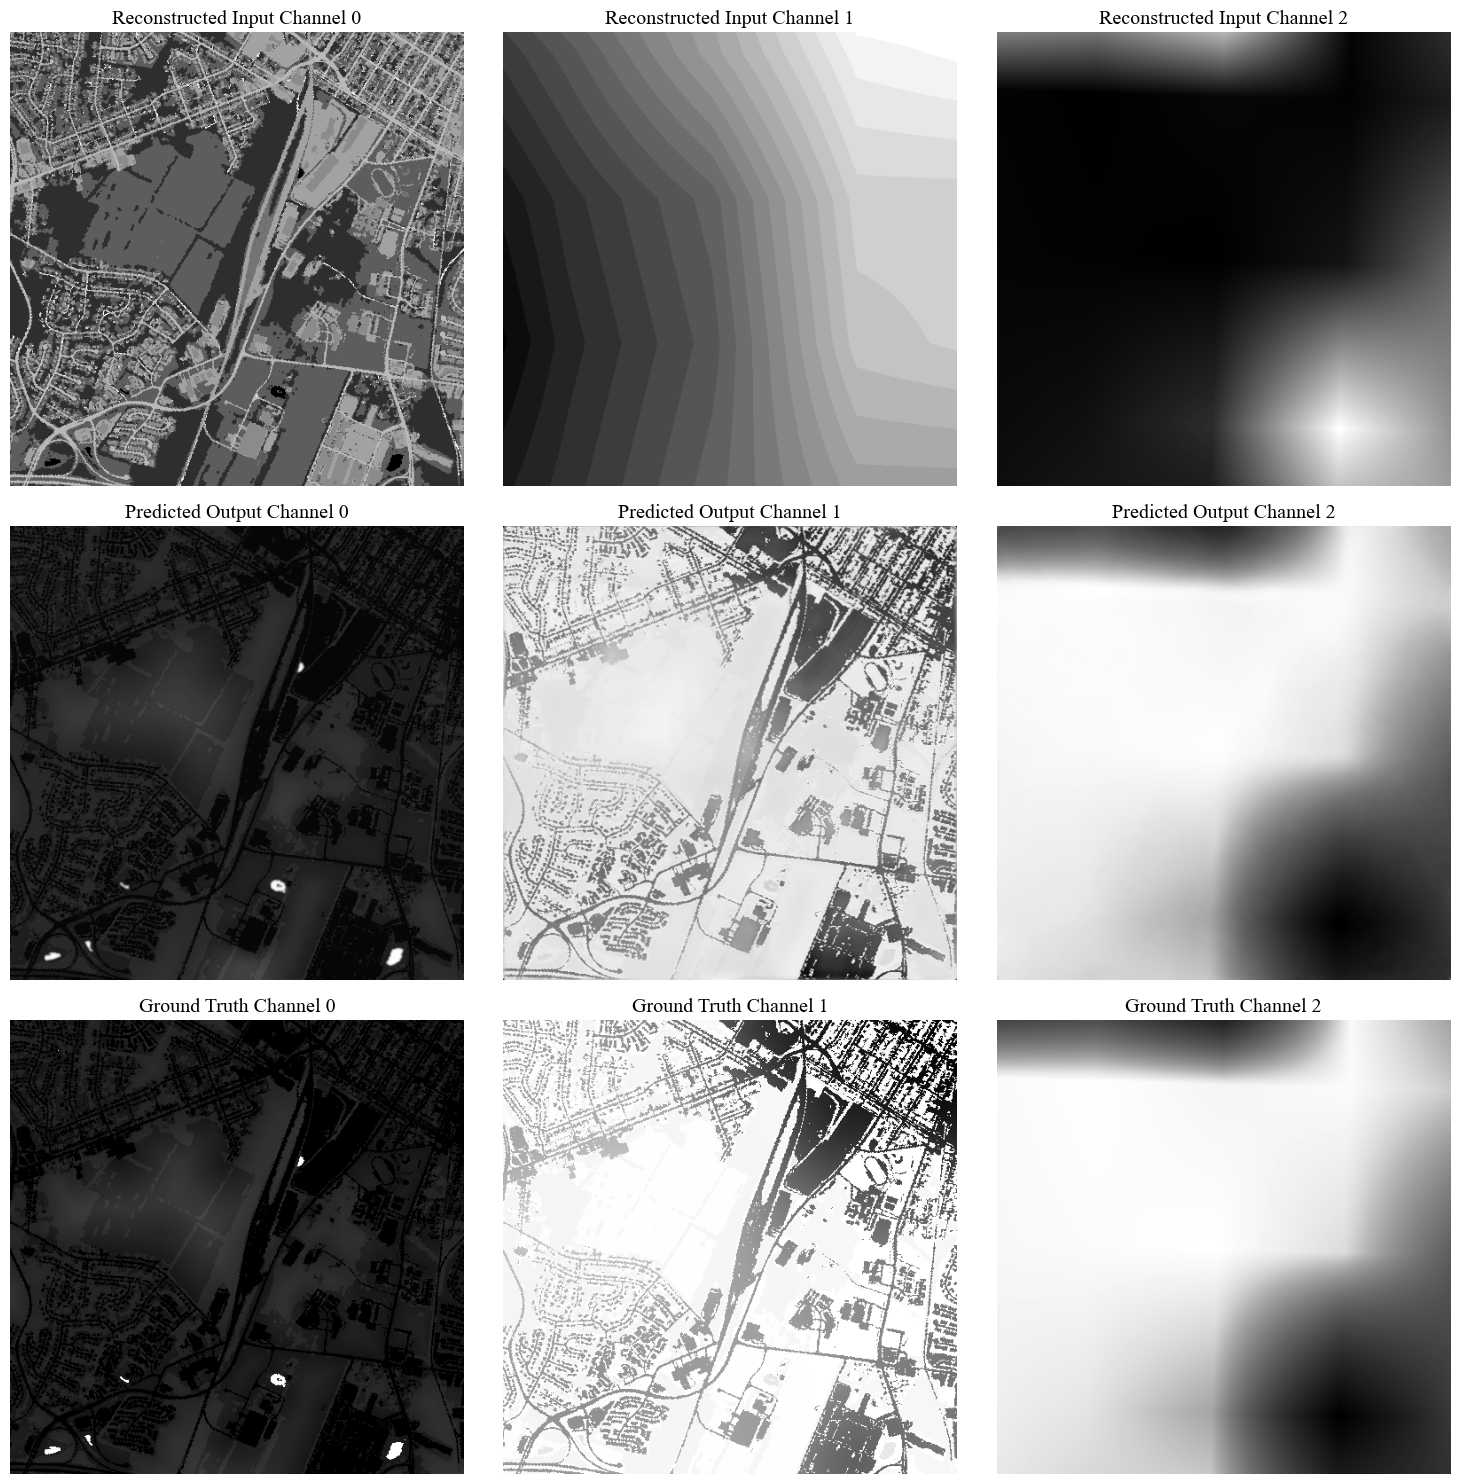

In [ ]:
import matplotlib.pyplot as plt
# set font to serif
plt.rcParams["font.family"] = "serif"

def visualize_prediction_with_conversion(model, val_loader, num_categories=14):
    """
    Visualizes one sample from the validation loader, converting the first 14 one-hot encoded channels
    back into the original form and displaying the input, predicted output, and ground truth.

    Parameters:
        model: The trained PyTorch model.
        val_loader: Validation DataLoader.
        num_categories: Number of categories in the one-hot encoded input.
    """
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Use the first sample from the batch
            single_input = inputs[0]  # Shape: (16, 512, 512)
            single_target = targets[0]  # Shape: (3, 512, 512)
            print(single_input.shape)
            print(single_target.shape)
            # Convert first 14 channels from one-hot encoding back to original 2D label map
            first_channel = torch.argmax(single_input[:num_categories], dim=0)  # Shape: (512, 512)
            print(first_channel.shape, single_input[num_categories:num_categories+2].shape)
            # Stack first channel and other two channels to simulate the original input
            reconstructed_input = torch.cat((first_channel.unsqueeze(0), single_input[num_categories:num_categories+2]), dim=0)  # Shape: (3, 512, 512)
            print(reconstructed_input.shape)
            # print the max value and the min value of each channel in reconstructed_input
            
            print(f"Channel {1} max value: {torch.max(single_input[-2])}")
            print(f"Channel {1} min value: {torch.min(single_input[-2])}")
            print(f"Channel {2} max value: {torch.max(single_input[-1])}")
            print(f"Channel {2} min value: {torch.min(single_input[-1])}")
            # Pass the reconstructed input through the model
            single_output = model(single_input.unsqueeze(0)).cpu().squeeze(0)

            # Plot results
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))

            # Plot reconstructed input channels
            for i in range(3):
                axes[0, i].imshow(reconstructed_input[i].cpu().numpy(), cmap='gray')
                axes[0, i].set_title(f'Reconstructed Input Channel {i}')
                axes[0, i].axis('off')

            # Plot predicted output channels
            for i in range(3):
                axes[1, i].imshow(single_output[i].cpu().numpy(), cmap='gray')
                axes[1, i].set_title(f'Predicted Output Channel {i}')
                axes[1, i].axis('off')

            # Plot ground truth channels
            for i in range(3):
                axes[2, i].imshow(single_target[i].cpu().numpy(), cmap='gray')
                axes[2, i].set_title(f'Ground Truth Channel {i}')
                axes[2, i].axis('off')

            plt.tight_layout()
            plt.show()
            break  # Only visualize one sample

# move model to cpu
model.to('cpu')
# Example usage:
visualize_prediction_with_conversion(model, val_loader) 